In [1]:
import numpy as np
import pandas as pd
import random
from pickle import dump
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ParameterGrid
# import tensorflow as tf
# import keras
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Flatten, Reshape, Conv1D
from keras.preprocessing.sequence import TimeseriesGenerator 
# from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import seaborn as sns
from numpy import array
from sklearn.impute import KNNImputer
import datetime
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from kerastuner.engine.hyperparameters import HyperParameters

<ipython-input-4-fda3582245ce>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [69]:
df = pd.read_excel("4_itbmpp_x_semana.xlsx")
Yu = df[["WEEK", "ITMBPP"]].dropna()
Yu = Yu.set_index("WEEK")

In [70]:
data1 = Yu[["ITMBPP"]]

Datos

In [133]:
# Normalizar datos
scaler = StandardScaler()
data = scaler.fit_transform(data1)
Ys_all = scaler.transform(data1)

# Dividir datos en entrenamiento y prueba
frac_datatrain = 0.95
train_size = int(len(data) * frac_datatrain)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size, :], data[train_size:len(data), :]

n_lag = 4
len_batch = 1

# Crear los generadores de series temporales para los conjuntos de entrenamiento y prueba
train_generator = TimeseriesGenerator(train_data, train_data[:, 0], length=n_lag, batch_size=len_batch, shuffle=False)
test_generator = TimeseriesGenerator(test_data, test_data[:, 0], length=n_lag, batch_size=len_batch, shuffle=False)
ts_all_uni = TimeseriesGenerator(Ys_all, Ys_all, length=n_lag, batch_size=len_batch, shuffle= False)

In [134]:
max_lr, max_b1, max_b2, max_e = 2.818382931264455e-05, 0.9, 0.9999, 1e-07

In [135]:
import os

In [136]:
#### Parametros

tf.random.set_seed(34)
os.environ['PYTHONHASHSEED']=str(34)
tf.keras.utils.set_random_seed(34)

#EPOCAS
MAX_EPOCHS = 100

#Early stop
paciencia = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, mode='min') #Early Stop

#Model parameters
perdida = tf.losses.MeanSquaredError()
metrica = [tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.losses.MeanSquaredError()]

#Optimizer

param_opt = {
    "learning_rate": max_lr,
    "beta_1" : max_b1,
    "beta_2" : max_b2,
    "epsilon": max_e}

optimizer_adam = tf.optimizers.Adam(learning_rate = param_opt['learning_rate'],
                                     beta_1 = param_opt["beta_1"],
                                     beta_2 = param_opt["beta_2"])

#### Modelo 
model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(n_lag, 1), return_sequences= True))
model.add(LSTM(64, activation='relu', input_shape=(n_lag, 1), return_sequences= True))
model.add(LSTM(32, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(32))
# model.add(Dense(16))
model.add(Dense(1))

model.compile(loss=tf.keras.losses.Huber(), 
        optimizer=optimizer_adam, 
        metrics=metrica)


lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 20**(epoch / 20))

### Model building
# history = model.fit(train_generator, 
#     validation_data = train_generator,  
#     epochs=MAX_EPOCHS, 
#     verbose=0,
#     callbacks = [lr_schedule])

history = model.fit(train_generator, 
    validation_data = train_generator,  
    epochs=MAX_EPOCHS, 
    verbose=0,
    callbacks = [])

In [142]:
vali_performance = {}
trai_performance= {}

In [143]:
# OPTIMUM LEARNING RATE
# lrs = 1e-8 * (10 ** (np.arange(len(history.history["loss"])) / 20))
# y_loss = history.history["loss"]
# index_minimum_loss = y_loss.index(min(y_loss))
# max_lr = lrs[index_minimum_loss]

# fig, ax =plt.subplots(1,1, figsize=(5, 4), sharex = False)
# plt.semilogx(lrs[0:], y_loss[0:])

In [144]:
max_lr

0.0008912509381337459

In [145]:
trai_performance["UNIV"] = scaler.inverse_transform(array(model.evaluate(train_generator, verbose = 0)[1]).reshape(-1,1))
vali_performance["UNIV"] = scaler.inverse_transform(array(model.evaluate(test_generator, verbose = 0)[1]).reshape(-1,1))
# PRIMER OUTPUT: LOSS (MSE) | # SEGUNDO OUTPUT: MAE | # PRIMER OUTPUT: MAE PERCENTAGE | # SEGUNDO OUTPUT: LOSS (MSE)
print(trai_performance, vali_performance)

{'UNIV': array([[38162.623564]])} {'UNIV': array([[32344.5910909]])}


In [146]:
# PREDICCIÓN
X_ini = Ys_all[-(len(test_data) + n_lag): ][:n_lag] #CREAR ARREGLO DE LOS (N_LAGS) VALORES PREVIOS 
X_ini = X_ini.reshape(1, n_lag, 1)

for i in range(len(test_data)):
    Y_pred = model.predict(X_ini[:, i : n_lag+i+1, :], verbose=0)
    X_ini = np.append(X_ini, Y_pred).reshape(1, len(X_ini[0])+1, 1)

X_ini = X_ini[0][n_lag:]

pred_p = X_ini.copy()

pred_p = scaler.inverse_transform(pred_p)
b = np.empty((len(train_data),1,))
b[:] = np.nan
pred_p = np.concatenate((b, pred_p), axis = 0)
pred_p = pred_p.reshape(-1)

#PREDICCIÓN EN ALL
yhat_all = model.predict(ts_all_uni, verbose=0)
yhat_all_level = scaler.inverse_transform(yhat_all)

a = np.empty((n_lag,1,))
a[:] = np.nan

# OBSERVADO EN ALL
yhat_all_level = np.concatenate((a, yhat_all_level),axis = 0)
yobs_test_level = scaler.inverse_transform(Ys_all)

# DATAFRAME
preds = pd.DataFrame(zip( yobs_test_level.reshape(len(yobs_test_level)), yhat_all_level.reshape(len(yhat_all_level)), pred_p),
            index = Yu.index,
            columns = ["OBSERVADO", "PREDICHO_ONESTEP", "PREDICHO_PRED"])

In [147]:
n = len(Yu)

<ipython-input-148-58e8de70300c>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


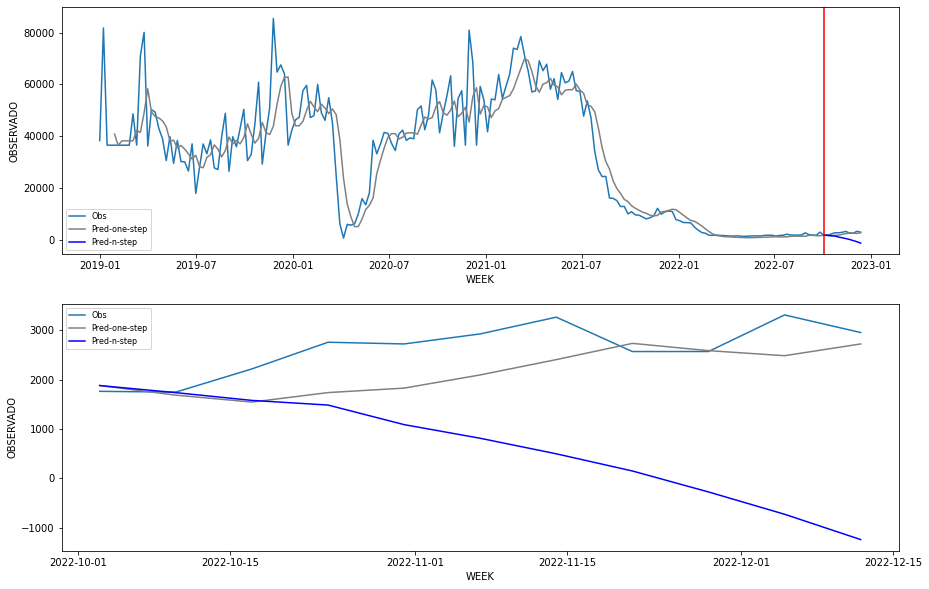

In [148]:
# VISUALIZAR
fig, ax =plt.subplots(2,1, figsize=(15, 10), sharex = False)

#PRIMERA GRÁFICA
sns.lineplot(x=preds.index, y=preds.OBSERVADO, ax = ax[0])
sns.lineplot(x=preds.index, y=preds.PREDICHO_ONESTEP, color = "gray", ax = ax[0])
sns.lineplot(x=preds.index, y=preds.PREDICHO_PRED, color = "blue", ax = ax[0])

ax[0].axvline(x=preds.index[int(n * frac_datatrain)], color='red')
ax[0].legend(labels=['Obs', 'Pred-one-step', 'Pred-n-step'], prop={'size': 8})
# ax[0].axis(ymin= 20015.12, ymax= 970278.39)


#SEGUNDA GRÁFICA
sns.lineplot(x=preds.index[int(n * frac_datatrain):][0:30], y=preds.OBSERVADO[int(n * frac_datatrain):][0:30], ax = ax[1])
sns.lineplot(x=preds.index[int(n * frac_datatrain):][0:30], y=preds.PREDICHO_ONESTEP[int(n * frac_datatrain):][0:30], color = "gray", ax = ax[1])
sns.lineplot(x=preds.index[int(n * frac_datatrain):][0:30], y=preds.PREDICHO_PRED[int(n * frac_datatrain):][0:30], color = "blue", ax = ax[1])

ax[1].legend(labels=['Obs', 'Pred-one-step', 'Pred-n-step'], prop={'size': 8})
# ax[1].axis(ymin= 320015.12, ymax= 970278.39)


fig.show()

<Axes: >

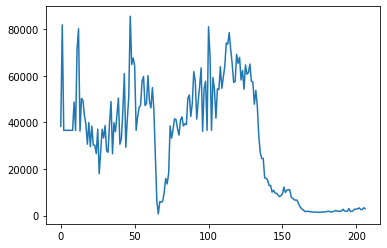

In [20]:
df["ITMBPP"].plot()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [40]:
import itertools

def train_and_evaluate(optimizer_choice, learning_rate):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_lag, 1), return_sequences=True))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(30))
    model.add(Dense(1))

    optimizer = None
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

    model.fit(train_generator, epochs=10, verbose=0)

    evaluation = model.evaluate(test_generator, verbose=0)
    return evaluation

optimizer_choices = ['adam', 'rmsprop', 'sgd']
learning_rates = [1e-4, 1e-3, 1e-2]

best_loss = float('inf')
best_params = None

# Buscar todas las combinaciones posibles de optimizador y tasa de aprendizaje
for optimizer_choice, learning_rate in itertools.product(optimizer_choices, learning_rates):
    loss = train_and_evaluate(optimizer_choice, learning_rate)

    if loss < best_loss:
        best_loss = loss
        best_params = (optimizer_choice, learning_rate)

print("Mejores hiperparámetros encontrados:")
print(f"Optimizador: {best_params[0]}, Tasa de aprendizaje: {best_params[1]}")

Mejores hiperparámetros encontrados:
Optimizador: rmsprop, Tasa de aprendizaje: 0.01


In [27]:
# Diseño inicial de la arquitectura
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_lag, 1), return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(30))
model.add(Dense(1))

# Selección del optimizador y ajuste de la tasa de aprendizaje
optimizer_adam = tf.optimizers.Adam()

# Función de pérdida y métricas
perdida = tf.losses.MeanSquaredError()
metrica = [tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.losses.MeanSquaredError()]

# Compilación del modelo
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer_adam,
              metrics=metrica)

# Early stopping y checkpoints
paciencia = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=paciencia, mode='min')

# Ajuste de hiperparámetros y regularización
# En este ejemplo, utilizaremos LearningRateScheduler para ajustar la tasa de aprendizaje
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 20**(epoch / 20))

# Entrenamiento del modelo
MAX_EPOCHS = 100
history = model.fit(train_generator, epochs=MAX_EPOCHS, verbose=2, callbacks=[early_stopping, lr_schedule], validation_data=test_generator)

# Evaluación del modelo
# Utiliza métricas adecuadas para evaluar el rendimiento del modelo en el conjunto de prueba
evaluation = model.evaluate(test_generator)

Epoch 1/100
3/3 - 4s - loss: 0.1914 - mean_absolute_error: 0.5978 - mean_absolute_percentage_error: 135983.3594 - mean_squared_error: 0.3736 - val_loss: 0.2070 - val_mean_absolute_error: 0.6305 - val_mean_absolute_percentage_error: 96.4002 - val_mean_squared_error: 0.4139 - lr: 1.0000e-08 - 4s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.1914 - mean_absolute_error: 0.5978 - mean_absolute_percentage_error: 135992.6875 - mean_squared_error: 0.3736 - val_loss: 0.2070 - val_mean_absolute_error: 0.6305 - val_mean_absolute_percentage_error: 96.4000 - val_mean_squared_error: 0.4139 - lr: 1.1616e-08 - 94ms/epoch - 31ms/step
Epoch 3/100
3/3 - 0s - loss: 0.1914 - mean_absolute_error: 0.5978 - mean_absolute_percentage_error: 135999.3906 - mean_squared_error: 0.3736 - val_loss: 0.2070 - val_mean_absolute_error: 0.6305 - val_mean_absolute_percentage_error: 96.3998 - val_mean_squared_error: 0.4139 - lr: 1.3493e-08 - 97ms/epoch - 32ms/step
Epoch 4/100
3/3 - 0s - loss: 0.1914 - mean_absolute_error: 

In [28]:
evaluation = model.evaluate(test_generator)

1/1 [==============================] - 0s 102ms/step - loss: 0.0087 - mean_absolute_error: 0.0981 - mean_absolute_percentage_error: 16.1510 - mean_squared_error: 0.0173


In [29]:
# Realizar predicciones en el conjunto de prueba
test_predictions = model.predict(test_generator)

# Invertir la normalización de las predicciones
test_predictions_inverse = scaler.inverse_transform(test_predictions)

# Invertir la normalización de los datos de prueba (Y)
test_targets = test_data[n_lag:, 0].reshape(-1, 1)
test_targets_inverse = scaler.inverse_transform(test_targets)

# Comparar las predicciones con los valores reales

1/1 [==============================] - 0s 448ms/step


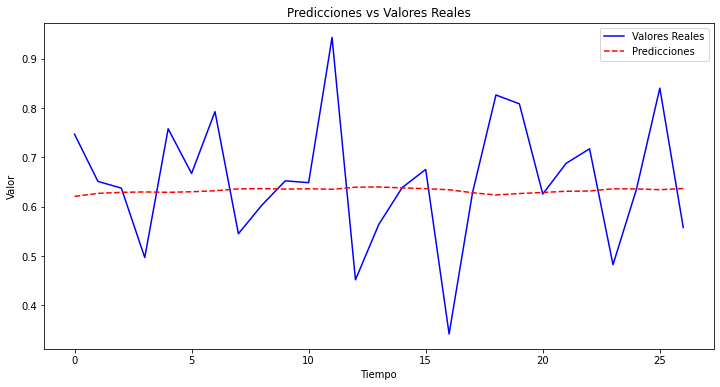

In [30]:
# Graficar las predicciones y los valores reales
plt.figure(figsize=(12, 6))
plt.plot(test_targets_inverse, label='Valores Reales', color='blue')
plt.plot(test_predictions_inverse, label='Predicciones', color='red', linestyle='--')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Predicciones vs Valores Reales')
plt.legend()
plt.show()